In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt

C:\Users\Alexis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from multiprocessing import Pool, Lock

lock = Lock()

def calculate_tau(window, ords, x):
    #print(ords, x)
    return kendalltau(ords, x)[0]

def add_kendall_tau(data, window=10):
    ords = range(window)
    l = [(window, ords, x) for x in data['Close'].rolling(window)]

    print(l)
    with Pool() as pool:
        data[f'Kendall_{window}'] = pool.starmap(
            calculate_tau,
            l
        )

    return data

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
minute = True

data = None
if minute:
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)
    
else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [5]:
# data = add_kendall_tau(data, 10)

In [6]:
crossover_horizon = 3
crossover_lag_horizon = 1

In [7]:
ma1, ma2, ma_mode = 5, 20, 'exponential'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, mode=ma_mode)

handler.data = ma_crossover_lagging_labelling(handler.data, ma1, ma2, crossover_lag_horizon, mode=ma_mode)
cross_lag_dummies = pd.get_dummies(handler.data[f'Crossover_Lag_{crossover_lag_horizon}'], prefix=f'Crossover_Lag_{crossover_lag_horizon}_') * 1
handler.data.drop(f'Crossover_Lag_{crossover_lag_horizon}', axis=1, inplace=True)
handler.data = pd.concat([handler.data, cross_lag_dummies], axis=1)


handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.TICK_DENSITY])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.PERC_RET,
                              Indicators.TICK_DENSITY])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[cross_lag_dummies.columns] = handler.data[cross_lag_dummies.columns]
predict_data.reset_index(drop=True, inplace=True)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_24972\3923993594.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_24972\3923993594.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_24972\3923993594.py:30: SettingWithCopyWar

In [8]:
# add_ichimoku(handler.data)

In [9]:
handler.data.iloc[0:30]

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,EMA5,EMA20,EMA5 Var,EMA20 Var,Close_EMA5_PERC_DIFF,Close_EMA20_PERC_DIFF,Label,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,TICK_DENSITY,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,PERC_RET,TICK_DENSITY Var
34,1502973000000,4417.00,4431.13,4411.01,4431.13,1.089877,4822.795465,16,4435.598651,4415.872588,-0.000503,0.000376,0.001008,-0.003443,0,0,1,0,56.872788,0,1,0,37.565903,-7.464012,38.797953,31.289223,24.732591,0.018613,900.0,0.038430,-0.071141,0.156699,-0.064990,0.027013,-0.057794,-1.128464,0.002945,0.0
35,1502973900000,4430.00,4431.13,4411.00,4411.00,0.846974,3742.258732,15,4427.399097,4415.395536,-0.001849,-0.000108,0.003718,0.000996,0,0,1,0,52.780438,0,1,0,33.277807,-9.401686,36.390743,29.455046,23.285676,-0.014200,900.0,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.004543,0.0
36,1502974800000,4411.00,4445.88,4411.00,4445.88,1.258943,5579.007948,10,4433.559400,4418.372185,0.001391,0.000674,-0.002771,-0.006187,0,0,1,0,58.370162,0,1,0,32.321404,-8.286472,34.856505,30.720371,20.989687,0.021412,900.0,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,0.007908,0.0
37,1502975700000,4430.43,4440.00,4422.60,4440.00,2.459375,10881.285906,14,4435.706267,4420.478957,0.000484,0.000477,-0.000967,-0.004397,0,0,1,0,57.142128,0,1,0,30.734690,-7.898548,33.478103,28.687260,19.600564,-0.040951,900.0,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,-0.001323,0.0
38,1502976600000,4435.12,4445.00,4425.21,4445.00,7.504640,33334.610602,41,4438.804178,4422.862383,0.000698,0.000539,-0.001394,-0.004980,0,0,1,0,57.952230,0,1,0,29.540146,-7.274474,32.447500,28.491775,18.480857,0.130296,900.0,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,0.001126,0.0
39,1502977500000,4432.07,4459.00,4425.60,4459.00,20.089478,89181.734979,53,4445.536120,4426.368056,0.001517,0.000793,-0.003019,-0.007318,0,0,1,0,60.219594,0,1,0,29.384418,-5.944161,32.074396,29.754515,16.742491,0.308588,900.0,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.003150,0.0
40,1502978400000,4459.00,4460.00,4435.93,4452.71,17.338465,77227.301286,52,4447.927413,4428.918943,0.000538,0.000576,-0.001074,-0.005343,0,0,1,0,58.688374,0,1,0,28.425778,-5.522241,31.775145,28.012819,15.603414,-0.203525,900.0,-0.025427,-0.032624,-0.070981,-0.009330,-0.068035,-0.058536,-1.659537,-0.001411,0.0
41,1502979300000,4452.71,4469.46,4437.35,4467.81,4.310344,19230.667327,52,4454.554942,4432.679041,0.001490,0.000849,-0.002967,-0.007863,0,0,1,0,61.236570,0,1,0,28.555325,-4.314156,31.865601,28.141784,14.214098,0.063525,900.0,0.043419,0.004557,-0.218767,0.002847,-0.089039,0.004604,-1.312125,0.003391,0.0
42,1502980200000,4467.81,4485.39,4452.57,4477.53,9.855382,44045.534290,72,4462.213295,4437.009103,0.001719,0.000977,-0.003421,-0.009050,0,0,1,0,62.826114,0,1,0,29.106789,-3.010153,32.495779,29.962311,12.945342,0.136572,900.0,0.025957,0.019312,-0.302261,0.019776,-0.089260,0.064691,1.149877,0.002176,0.0
43,1502981100000,4477.53,4477.53,4453.26,4470.82,20.231706,90367.950462,58,4465.082197,4440.269065,0.000643,0.000735,-0.001283,-0.006833,-1,0,1,0,60.967498,0,1,0,28.671876,-2.756053,33.069595,27.973808,12.086201,-0.246674,900.0,-0.029583,-0.014942,-0.084414,0.017658,-0.066367,-0.066367,-2.806185,-0.001499,0.0


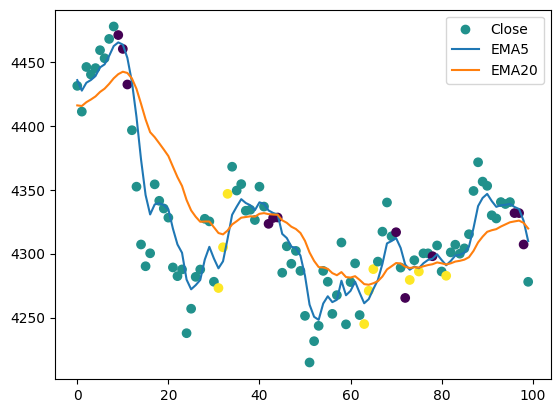

In [10]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][0:100], label=f"{ma_name}{ma1}")
plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][0:100], label=f"{ma_name}{ma2}")
plt.legend()
plt.show()

[ 191 1987 2447 2931]
[  376  3155  4064  5278  6030  6725  8296 10313]
[3313 3695 4456 4916]
[ 6030  6725  8296 10313 11651 12609 14598 15711]
[5523 5904 6381 7054]
[11651 12609 14598 15711 16304 19167 19684 21988]
[ 7544  7902  8982 10601]
[16304 19167 19684 21988 22648 23365 25601 26755]
[11279 11848 13300 13806]
[22648 23365 25601 26755 27973 29231 30111 31651]
[15211 15887 17725 18314]
[27973 29231 30111 31651 32431 33307 34728 35322]
[20005 20464 21276 22351]
[32431 33307 34728 35322 36805 37569 38757 39437]
[23053 23858 24425 25863]
[36805 37569 38757 39437 40583 41232 42062 43276]
[26336 27445 28653 29620]
[40583 41232 42062 43276 44299 48630 49794]
[31100 32016 32557 33921]
[44299 48630 49794]


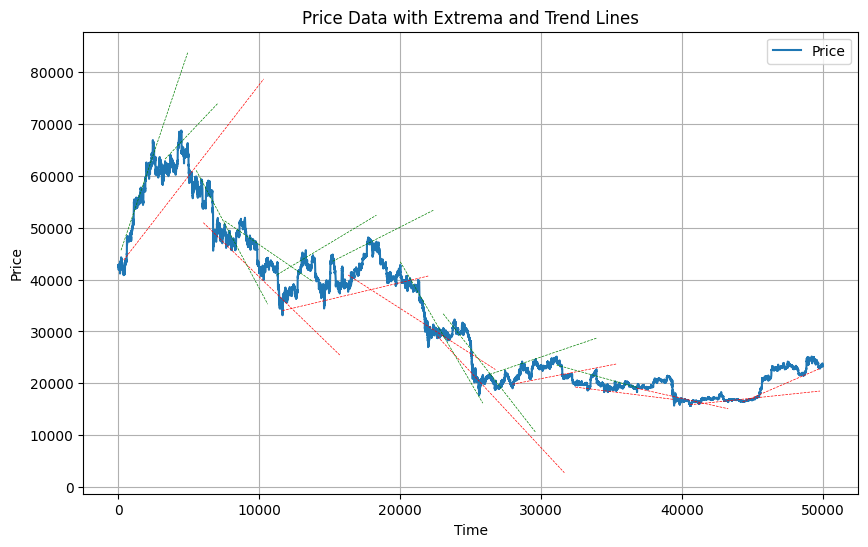

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.optimize import least_squares

def generate_price_data(n_points):
    x = np.linspace(0, 10, n_points)
    noise = np.random.normal(0, 0.1, n_points)
    price = np.sin(x) + noise
    return x, price

def find_extrema(price, order):
    peaks_idx = argrelextrema(price, np.greater, order=order)[0]
    valleys_idx = argrelextrema(price, np.less, order=order)[0]
    return peaks_idx, valleys_idx

def fit_trend_line(x, y):
    def objective_func(params, x, y):
        return params[0] * x + params[1] - y

    params_init = np.polyfit(x, y, 1)
    result = least_squares(objective_func, params_init, args=(x, y))
    return result.x

def plot_price_with_extrema_trend(x, price, peaks_idx, valleys_idx, support_lines, resistance_lines):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, price, label='Price')
    # plt.plot(x[peaks_idx], price[peaks_idx], 'ro', label='Peaks')
    # plt.plot(x[valleys_idx], price[valleys_idx], 'go', label='Valleys')

    # Plot trend lines
    for idx in support_lines:
        trend_line = support_lines[idx]
        plt.plot(trend_line[0], trend_line[1], 'r--', linewidth=0.5)

    for idx in support_lines:
        trend_line = resistance_lines[idx]
        plt.plot(trend_line[0], trend_line[1], 'g--', linewidth=0.5)

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Price Data with Extrema and Trend Lines')
    plt.legend()
    plt.grid(True)
    plt.show()

window = 50000

# Generate price data
x, price = generate_price_data(100)
x, price = np.arange(window), np.array(handler.data['Close'])[-window:]

# Find extrema (peaks and valleys)
_, valleys_idx = find_extrema(price, 500)
peaks_idx, _ = find_extrema(price, 300)

# Define lookback thresholds
threshold = 4

# Fit trend lines based on lookback thresholds
support_lines = {}
resistance_lines = {}

i = 0
while i < valleys_idx.size:
    valleys = valleys_idx[i:i+threshold]
    trend_line_x = x[valleys]
    trend_line_y = fit_trend_line(trend_line_x, price[valleys])
    # print(trend_line_x, trend_line_y)

    valleys = valleys_idx[i:i+2*threshold]
    trend_line_x = x[valleys[0]:valleys[-1]]
    support_lines[i] = (trend_line_x, trend_line_y[0] * trend_line_x + trend_line_y[1])
    
    peaks = peaks_idx[i:i+threshold]
    print(peaks)
    print(valleys)
    trend_line_x = x[peaks]
    trend_line_y = fit_trend_line(trend_line_x, price[peaks])
    # print(trend_line_x, trend_line_y)

    peaks = peaks_idx[i:i+2*threshold]
    trend_line_x = x[peaks[0]:peaks[-1]]
    resistance_lines[i] = (trend_line_x, trend_line_y[0] * trend_line_x + trend_line_y[1])
    
    i += threshold

# Plot price data with extrema and trend lines
plot_price_with_extrema_trend(np.array(range(price.shape[0])), price, peaks_idx, valleys_idx, support_lines, resistance_lines)


In [12]:
valleys_idx

array([  376,  3155,  4064,  5278,  6030,  6725,  8296, 10313, 11651,
       12609, 14598, 15711, 16304, 19167, 19684, 21988, 22648, 23365,
       25601, 26755, 27973, 29231, 30111, 31651, 32431, 33307, 34728,
       35322, 36805, 37569, 38757, 39437, 40583, 41232, 42062, 43276,
       44299, 48630, 49794], dtype=int64)